---
title: "Running a Local Vision Language Model with LM Studio to sort out my screenshot mess"
description: "How I used a VLM to sort out my screenshot mess"
author: "Daniel van Strien"
date: "2024-10-23"
image: illustration.png 
aliases:
  - local-vlm-with-lm-studio
toc: true
toc-depth: 3

---



*tl;dr* I used a VLM to sort out my screenshot mess using a local VLM. 

There are many reasons you might prefer to run a local model, including privacy, speed, cost, or just plain old curiosity. 

Running Local Language Models has become increasingly easy over the last year. This is in a huge part thanks to the work of [George Gersonov](https://github.com/ggerganov) on [`llama.cpp`](https://github.com/ggerganov/llama.cpp). `llama.cpp` is used under the hood by a growing number of UI tools like [LM Studio](https://lmstudio.ai/).

Recently LM Studio has added additonal support for running models on Macs with Apple Silicon via [mlx-engine](https://github.com/lmstudio-ai/mlx-engine) which uses Apple's [MLX](https://github.com/ml-explore/mlx) library to accelerate the inference of models on Macs with Apple Silicon. The most recent [release](https://lmstudio.ai/blog/lmstudio-v0.3.5) of LM Studio has also added two very exciting features:

1. Headless mode, which allows you to run models without a GUI. This is great for background processing tasks.
2. Support for Vision Language Models (via [mlx-vlm](https://github.com/lmstudio-ai/mlx-vlm)). Vision Language Models (VLMs) are a type of model that can process both text and images.

In addition to these two features, LM Studio already had support for Structued Outputs (using [Outlines](https://docs.lmstudio.ai/guides/structured-outputs/)). In this blog post I'll show how these new features can be used for a perfect local VLM task: sorting out my chaotic desktop 😅. 

## The Problem

I have hundreds of screenshots on my desktop. Some of them are screenshots of code, some are screenshots of webpages, some are screenshots of videos, some are screenshots of stupid memes, etc. 

I'd like to be able to automatically sort these screenshots in a way that I can find them later or at least shove them into some kind of order so that my desktop doesn't look like a screenshot graveyard. 

Let's see how we can use VLM's and LM Studio to tackle this problem!

### What we're working with

To start with lets see what we're working with. 

In [14]:
from pathlib import Path
from PIL import Image

In [16]:
screenshots = list(Path("/Users/davanstrien/Desktop").glob("Screenshot*.png"))
screenshots[3]

PosixPath('/Users/davanstrien/Desktop/Screenshot 2024-10-03 at 09.14.30.png')

![Example of the type of screenshots I have hundreds of on my desktop](example_screenshot.png){width=50%}


## Setting up a local VLM

If you haven't already, you will need to install LM Studio. You can find the latest instructions on their [website](https://lmstudio.ai/). If you already have LM Studio installed make sure you are running at least version 0.3.5.


### Enabling LM Studio Headless Mode

Whilst not necessary for running a VLM, Label Studio added a new feature for running in headless mode in version 0.3.5. This allows you to run the VLM without a GUI. This can be very nice if you want to use a VLM or an LLM in the background for some task(s). 

To enable headless mode, go to the settings menu and check the "Enable Local LLM Service" option.

![](https://lmstudio.ai/assets/docs/headless-settings.png)

In addition to this, we'll use the CLI to interact with Label Studio. Check out the [docs](https://lmstudio.ai/docs/cli) for more information on how to set this up.

Let's see what the `lms` CLI has available.

In [11]:
!lms

   __   __  ___  ______          ___        _______   ____
  / /  /  |/  / / __/ /___ _____/ (_)__    / ___/ /  /  _/
 / /__/ /|_/ / _\ \/ __/ // / _  / / _ \  / /__/ /___/ /  
/____/_/  /_/ /___/\__/\_,_/\_,_/_/\___/  \___/____/___/  

lms - LM Studio CLI - v0.0.27
GitHub: https://github.com/lmstudio-ai/lmstudio-cli

Usage
lms <subcommand>

where <subcommand> can be one of:

- status - Prints the status of LM Studio
- server - Commands for managing the local server
- ls - List all downloaded models
- ps - List all loaded models
- get - Searching and downloading a model from online.
- load - Load a model
- unload - Unload a model
- create - Create a new project with scaffolding
- log - Log operations. Currently only supports streaming logs from LM Studio via `lms log stream`
- import - Import a model file into LM Studio
- version - Prints the version of the CLI
- bootstrap - Bootstrap the CLI

For more help, try running `lms <subcommand> --help`


As you can see we have a bunch of commands for interacting with the local LLM service. We'll srart by downloading a VLM model. For now LM Studio has support for [Pixtral](https://huggingface.co/mistral-community/pixtral-12b) (specifcally using a MLX 4 bit quantised model [mlx-community/pixtral-12b-4bit](https://huggingface.co/mlx-community/pixtral-12b-4bit)). 

LM studio allows us to directly download models from Hugging Face. Let's download the Pixtral model!

In [12]:
%%bash
lms get mlx-community/pixtral-12b-4bit 

Searching for models with the term mlx-community/pixtral-12b-4bit
Based on your hardware, choosing the recommended option: Pixtral 12B [4bit] (7.15 GB)
You already have this model. You can load it with: 

    lms load pixtral-12b



You'll see above I already have the model downloaded but if you don't the CLI will download it for you.

Once the model is downloaded we can load it into LM Studio.


In [13]:
%%bash
lms load pixtral-12b


Loading model "mlx-community/pixtral-12b-4bit"...
[LMStudioClient][LLM] Start loading model mlx-community/pixtral-12b-4bit...
Model loaded successfully in 9.62s. (7.15 GB)
To use the model in the API/SDK, use the identifier "pixtral-12b".
To set a custom identifier, use the --identifier <identifier> option.


⠴ [████████████████████████████████▏                 ] 64.16%          

We'll also want to start a server so we can interact with the model via an API. 

In [14]:
%%bash
lms server start

Starting server...
Success! Server is now running on port 1234


The server will be available at `http://localhost:1234`. The API is largely compatible with the OpenAI API so if you've used that before you'll feel right at home. We can start by checking what models are available.

In [15]:
%%bash
curl http://localhost:1234/v1/models

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed


100   142  100   142    0     0  59638      0 --:--:-- --:--:-- --:--:-- 71000


{
  "data": [
    {
      "id": "pixtral-12b",
      "object": "model",
      "owned_by": "organization_owner"
    }
  ],
  "object": "list"
}

## Using the OpenAI Client to interact with the VLM

We can use the OpenAI client to interact with the VLM. This is useful if you want to use a VLM in a script or other program. Using this Client will also make it easier for us to switch out the VLM in the future without having to change the API calls. Let's start by seeing how we can create the client. 

The import is exactly the same as for the OpenAI API.


In [2]:
from openai import OpenAI

We need to point to our local server and use the API key `lm-studio`. The server will usually be available on port `1234`. 


In [3]:
client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")

We can now see what models are available via Python.

In [4]:
client.models.list()

SyncPage[Model](data=[Model(id='pixtral-12b', created=None, object='model', owned_by='organization_owner')], object='list')

In [6]:
completion = client.chat.completions.create(
    model="pixtral-12b",
    messages=[
        {"role": "system", "content": "Always respond with a pointless anecdote."},
        {"role": "user", "content": "Hello, how are you?"},
    ],
    temperature=0.7,
)

In [9]:
from rich import print

print(completion.choices[0].message.content)

Oh, hey there! You know, I was just thinking about the time I tried to make a sandwich with a banana instead of 
bread? It was a slippery slope, literally and metaphorically. I ended up with a mess of banana goo and a serious 
case of the giggles. Who knew making a sandwich could be so... slippery!

Very nice! Now let's try with an image. 

### Passing Images to the VLM

Let's try with an image. We need to encode the image to base64 to send it to the VLM via the API.


In [18]:
# encode the image to base64
import base64
import io

image = Image.open(screenshots[-3])
# Convert PIL Image to RGB mode
image_rgb = image.convert("RGB")

# Convert PIL Image to bytes
img_byte_arr = io.BytesIO()
image_rgb.save(img_byte_arr, format="JPEG")
image_bytes = img_byte_arr.getvalue()

# Encode to base64
base64_image = base64.b64encode(image_bytes).decode("utf-8")

We can see the base64 encoded image below.


In [19]:
base64_image

'/9j/4AAQSkZJRgABAQAAAQABAAD/4QHgaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wLwA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA2LjAuMCI+CiAgIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAgICAgICAgIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIj4KICAgICAgICAgPGV4aWY6UGl4ZWxZRGltZW5zaW9uPjE1NDQ8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNpb24+OTU2PC9leGlmOlBpeGVsWERpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6VXNlckNvbW1lbnQ+U2NyZWVuc2hvdDwvZXhpZjpVc2VyQ29tbWVudD4KICAgICAgPC9yZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+Cv/bAEMACAYGBwYFCAcHBwkJCAoMFA0MCwsMGRITDxQdGh8eHRocHCAkLicgIiwjHBwoNyksMDE0NDQfJzk9ODI8LjM0Mv/bAEMBCQkJDAsMGA0NGDIhHCEyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMv/AABEIBggDvAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnK

Let's try again with the base64 encoded image.

In [20]:
completion = client.chat.completions.create(
    model="pixtral-12b",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "What is this image about?",
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
            ],
        },
    ],
)

Let's see the response.


In [21]:
print(completion.choices[0].message.content)

The image appears to be a screenshot of a configuration interface for setting up an endpoint, likely in the context
of deploying or managing a containerized application. Here's a breakdown of the various sections and fields in the 
interface:

### General Configuration
1. **Automatic Scaling**:
   - **Min**: 0 (Minimum number of replicas)
   - **Max**: 1 (Maximum number of replicas)

2. **Revision**:
   - An optional field to specify a revision identifier, e.g., `b754fe8f941023b372bd6a6c17282cf4bb9c0`.

### Task and Framework
- **Task**: Set to "Custom".
- **Framework**: Also set to "Custom".

### Container Type
- The default container type is used for deploying endpoints, which is flexible due to custom inference handlers. 
Options include:
  - Custom
  - Test-Generation information
  - Link to a custom container

### Container Details
- **Container URL**: `danielvanstreien/aria-vlim.latest`
  - This is the registry URL for the container, which can be from various registries like Docker Hub, AWS ECR, 
Azure ACR, Google GCR, etc.
- **Container Port**: 8000
- **Health Route**: `/health`
- **Username** and **Password**:
  - These fields are optional for authentication to the container registry.

### Environment Variables
- **Default**:
  - Key: `CLIENT_KEY`
  - Value: (To be filled in)
- **Secrets**:
  - Key: `CLIENT_KEY`
  - Value: (To be filled in)

### Additional Options
- **Add one**: Allows adding more environment variables or secrets.

### Summary
This interface is used to configure an endpoint for a containerized application, specifying details such as the 
number of replicas, revision identifier, task and framework settings, container registry URL, port, health route, 
and environment variables. The configuration allows for flexibility in deploying the application with custom 
settings and secure handling of sensitive information like client keys.

Very nice! This is already pretty cool but there are still some challenges if we want to use the VLM for more than a simple chat and actually want to use the VLM to allow us to perform some other kinds of tasks or actions. For example we might want to sort screenshots into categories or tags. One way we can do this is by asking the VLM to output this kind of info as JSON. Let's try this. 

We never knew a few years ago that we would spend so much time looking at deeply nested lists of Dicts 😅 so let's extract out the prompt to make it a bit easier to see what we're changing. 



In [22]:
prompt = """What is this image about? Assign a maximum of 3 tags to the image, and put the image into one of the following categories: meme, documentation image, other.
Respond in JSON format with the keys "description", "category", and "tags"."""

In [23]:
# | code-fold: true
# | code-summary: "Show the code"
# | code-overflow: wrap
# | output-fold: true

completion = client.chat.completions.create(
    model="pixtral-12b",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt,
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
            ],
        },
    ],
)

Let's see the response.

In [24]:
print(completion.choices[0].message.content)

```json
{
  "description": "Configuration settings for deploying a containerized application.",
  "image_url": "https://example.com/container-image",
  "endpoint_settings": {
    "scale_to_zero": true,
    "idle_timeout": 300,
    "replicas": {
      "min": 0,
      "max": 1
    },
    "revision": "e.g. b754fe8f941023b372bd6adcba6c17282cf4bb9c0",
    "task": "Custom",
    "framework": "Custom"
  },
  "container_type": {
    "default_container": true,
    "custom_inference_handlers": false
  },
  "container_url": {
    "registry_url": "danielvanstraten/aria-vilm:latest",
    "container_port": 8000,
    "health_route": "/health"
  },
  "authentication": {
    "username": "",
    "password": ""
  },
  "environment_variables": {
    "default": [
      {
        "key": "CLIENT_KEY",
        "value": ""
      }
    ],
    "secrets": [
      {
        "key": "CLIENT_KEY",
        "value": ""
      }
    ]
  }
}
```

This is sort of what we asked for but not really? Let's try to parse the response as JSON. 

In [25]:
import json

json.loads(completion.choices[0].message.content)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In this case we can fix this by stripping the ````json` from the response but it's not a great solution. 

In [26]:
json.loads(completion.choices[0].message.content.strip("```json"))
## Structured output

{'description': 'Configuration settings for deploying a containerized application.',
 'image_url': 'https://example.com/container-image',
 'endpoint_settings': {'scale_to_zero': True,
  'idle_timeout': 300,
  'replicas': {'min': 0, 'max': 1},
  'revision': 'e.g. b754fe8f941023b372bd6adcba6c17282cf4bb9c0',
  'task': 'Custom',
  'framework': 'Custom'},
 'container_type': {'default_container': True,
  'custom_inference_handlers': False},
 'container_url': {'registry_url': 'danielvanstraten/aria-vilm:latest',
  'container_port': 8000,
  'health_route': '/health'},
 'authentication': {'username': '', 'password': ''},
 'environment_variables': {'default': [{'key': 'CLIENT_KEY', 'value': ''}],
  'secrets': [{'key': 'CLIENT_KEY', 'value': ''}]}}

## Structured output to the rescue! 

I bang on about structured generation so much it probably seems like I've put my entire pension into a structured generation ETF but IMO it's a massively useful tool for using LLMs to do productive work. In particular it makes it easier to use LLMs for tasks that require more than just a simple chat i.e where you want to use the LLM to do something like sort images into folders or categorize them or generate metadata or perform API calls...It's also massively useful for generating synthetic data for training other models (to the point where I think I will often prefer to use a crappier model that can be used with structured generation than a better model that can't).i

As we saw above the JSON returned wasn't very close to what we asked for. We could try and fix this by iterating on the prompt but alongisde doing we can also enforce a certain output. This doesn't mean the output will always be *correct* but at least it will have the correct format and be *consistent*. This is already very helpful to avoid having to write parsing prompts like

```python

def try_and_parse_response(response):
    if response.startswith("```json"):
        return json.loads(response.strip("```json"))
    else:
        if response.startswith("```"):
            return json.loads(response.strip("```"))
        else:
            raise ValueError("Response is not valid JSON")
```
This can get annoying very quickly so let's see how we can use structured output to enforce a certain format. 


### Defining a Pydantic Class with Outlines 

LM Studio has support for structured outputs via [Outlines](https://lmstudio.ai/docs/advanced/structured-output) for `mlx` models. For `gguf` models it uses llama.cpp's grammar-based sampling APIs.

Let's see how we can use a Pydantic model to enforce a certain output. To start if we wanted to sort images into folder's we likely don't want the model to keeping adding new folders to the folder structure. Instead we may want to only allow a certain set of categories. We can do this by defining a Pydantic model. 


In [30]:
from pydantic import BaseModel, Field
from typing import Literal


class ScreenshotCategory(BaseModel):
    category: Literal["meme", "documentation image", "other"] = Field(
        ..., description="The category of the screenshot"
    )

This tells the model that the category must be one of the three options and that it must be a string. We can also add more constraints and combine classes. Let's create an overall Class to represent the output we want for each screenshot. 

We'll ask for:

- A description of the screenshot: we will enforce a minimum and maximum length so we don't get some really long or really short descriptions. 
- A category: we will use our `ScreenshotCategory` class to enforce the category. 
- We'll give the model a bit more choice with the tags by allowing up to 3 optional tags.

In [34]:
from typing import Annotated
from pydantic.types import StringConstraints
from typing import Optional, List


class ScreenshotInformation(BaseModel):
    description: Annotated[str, StringConstraints(min_length=50, max_length=500)] = (
        Field(
            ..., description="A short description of the screenshot (50-200 characters)"
        )
    )
    category: ScreenshotCategory
    tags: Optional[List[str]] = Field(
        None, description="A list of tags that describe the screenshot", max_items=3
    )

Let's update our prompt to ask for this information and specify that the response should be in JSON format. 


In [35]:
prompt = f"""Analyze the given screenshot and provide the following information in JSON format:

1. description: A short description of the screenshot (50-200 characters)
2. category: Categorize the screenshot as one of the following:
   - meme
   - documentation image
   - other
3. tags: (Optional) Up to 3 tags that describe the screenshot

Ensure your response follows this schema:
{ScreenshotInformation.model_json_schema()}

Do not include any explanations or additional text outside of the JSON structure."""

In [36]:
# | code-fold: true
# | code-summary: "Show the code"
# | code-overflow: wrap
# | output-fold: true

completion = client.beta.chat.completions.parse(
    model="model-identifier",
    messages=[
        {
            "role": "system",
            "content": """You are an AI assistant specialized in organizing a users screenshots into categories and tags.
            """,
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt,
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
            ],
        },
    ],
    max_tokens=2000,
    temperature=0.7,
    response_format=ScreenshotInformation,
)

In [33]:
print(completion.choices[0].message.parsed)

ScreenshotInformation(
    description='Configuration settings for deploying a container endpoint.',
    category=ScreenshotCategory(category='documentation image'),
    tags=['Technology', ',', 'Configuration settings']
)

We can see that we now get back a `ScreenshotInformation` object rather than a string. This is already pretty cool. You might spot though that one of the tags is just a `,`, whilst this is "technically" correct it's not what we want. We can fix this by updating our Pydantic model. We can also add a constraint to the tags to ensure they are at least 3 characters long. 

In [40]:
from typing import Annotated, List, Optional
from pydantic import BaseModel, Field
from pydantic.types import StringConstraints


class ScreenshotCategory(BaseModel):
    category: Literal["meme", "documentation image", "other"] = Field(
        ..., description="The category of the screenshot"
    )


class ScreenshotInformation(BaseModel):
    description: Annotated[str, StringConstraints(min_length=50, max_length=1000)] = (
        Field(
            ..., description="A short description of the screenshot (50-200 characters)"
        )
    )
    category: ScreenshotCategory
    tags: Optional[List[Annotated[str, StringConstraints(min_length=3)]]] = Field(
        None, description="A list of tags that describe the screenshot", max_items=3
    )

In [41]:
prompt = f"""Analyze the given screenshot and provide the following information in JSON format:

1. description: A short description of the screenshot (50-200 characters)
2. category: Categorize the screenshot as one of the following:
   - meme
   - documentation image
   - other
3. tags: (Optional) Up to 3 tags that describe the screenshot

Ensure your response follows this schema:
{ScreenshotInformation.model_json_schema()}

Do not include any explanations or additional text outside of the JSON structure."""

In [42]:
# | code-fold: true
# | code-summary: "Show the code"
# | code-overflow: wrap
# | output-fold: true

completion = client.beta.chat.completions.parse(
    model="model-identifier",
    messages=[
        {
            "role": "system",
            "content": """You are an AI assistant specialized in organizing a users screenshots into categories and tags.
            """,
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt,
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
            ],
        },
    ],
    max_tokens=2000,
    temperature=0.7,
    response_format=ScreenshotInformation,
)

Let's see how this changes the output.


In [45]:
print(completion.choices[0].message.parsed)

ScreenshotInformation(
    description='Configuration page for deploying a container with various settings including security, networking,
and environment variables.',
    category=ScreenshotCategory(category='documentation image'),
    tags=['.NET', 'API', 'AWS ECR']
)

The tags could potentially be improved but we already have an output that means we can use this in a program. To make this a bit easier to use let's wrap this up in a function. 

In [66]:
from typing import Union


def encode_image_to_base64(image):
    img_byte_arr = io.BytesIO()
    image.save(img_byte_arr, format="JPEG")
    image_bytes = img_byte_arr.getvalue()
    return base64.b64encode(image_bytes).decode("utf-8")


def analyze_screenshot(image: Image.Image, prompt, return_class):
    image = image.convert("RGB")
    base64_image = encode_image_to_base64(image)
    completion = client.beta.chat.completions.parse(
        model="model-identifier",
        messages=[
            {
                "role": "system",
                "content": """You are an AI assistant specialized in organizing a users screenshots into categories and tags.
            """,
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt,
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                    },
                ],
            },
        ],
        max_tokens=2000,
        temperature=0.7,
        response_format=return_class,
    )
    return completion.choices[0].message.parsed

Let's now try with another screenshot. 

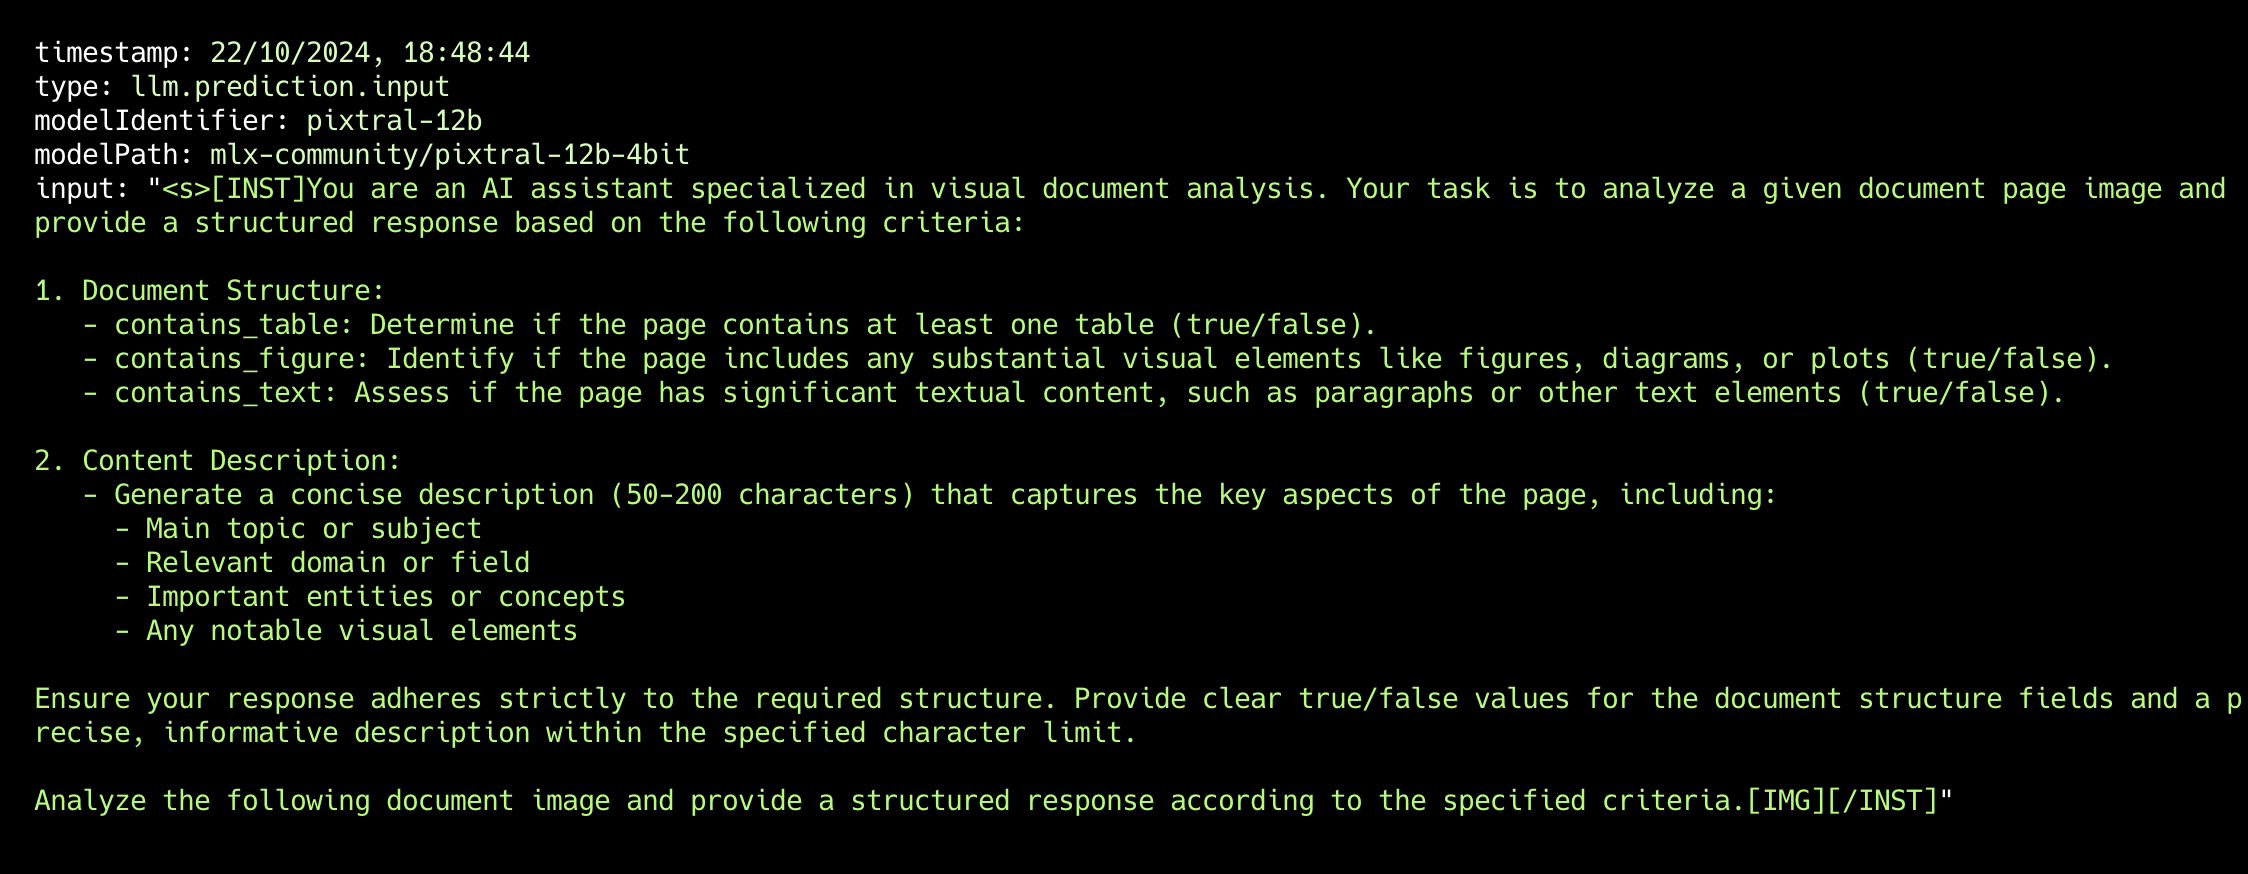

In [58]:
image = Image.open(screenshots[0])
image

In [57]:
analyze_screenshot(screenshots[0], prompt, ScreenshotInformation)

ScreenshotInformation(description='This screenshot shows a list of instructions for analyzing document images.', category=ScreenshotCategory(category='documentation image'), tags=None)

To make sure memes are detected let's try with a meme. 

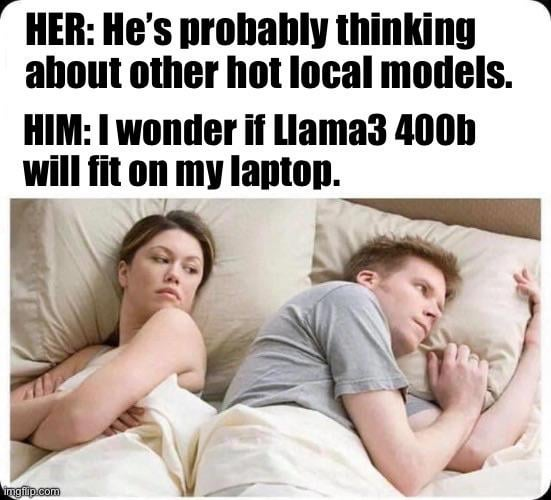

In [67]:
url = "https://preview.redd.it/this-meme-only-runs-on-an-h100-v0-urpjifh14xcd1.jpeg?auto=webp&s=7be0109b54cef2cd268659cb29727f6e16462621"
image = Image.open(requests.get(url, stream=True).raw)
image

In [77]:
screenshot_info = analyze_screenshot(image, prompt, ScreenshotInformation)
screenshot_info

ScreenshotInformation(description='The couple is discussing Llama3 400b while in bed.', category=ScreenshotCategory(category='meme'), tags=['relationship', 'humor', 'tech'])

## Organizing the screenshots aka we don't need claude to interact with our machines!

We can now use this to organize our screenshots. We'll create a new folder on our desktop and move the screenshots into the appropriate folders. 

In [76]:
folders = ["meme", "other", "documentation_image"]
base_desktop_folder = "/Users/davanstrien/Desktop/organized_screenshots"
for folder in folders:
    Path(f"{base_desktop_folder}/{folder}").mkdir(exist_ok=True, parents=True)

In [80]:
screenshot_info.category.category

'meme'

We define a mapping from the category to the folder on our desktop.

In [81]:
import shutil

category_folder_map = {
    "meme": Path(base_desktop_folder) / "meme",
    "other": Path(base_desktop_folder) / "other",
    "documentation image": Path(base_desktop_folder) / "documentation_image",
}

category_folder_map

{'meme': PosixPath('/Users/davanstrien/Desktop/organized_screenshots/meme'),
 'other': PosixPath('/Users/davanstrien/Desktop/organized_screenshots/other'),
 'documentation image': PosixPath('/Users/davanstrien/Desktop/organized_screenshots/documentation_image')}

and a function to move the screenshot to the appropriate folder. Let's try with the first screenshot. 


In [82]:
def organize_screenshot(image_path):
    image = Image.open(image_path).convert("RGB")
    analysis = analyze_screenshot(image, prompt, ScreenshotInformation)
    category = analysis.category.category
    print(f"Moving {image_path} to {category_folder_map[category]}")
    shutil.move(image_path, category_folder_map[category] / image_path.name)


organize_screenshot(screenshots[0])

Moving /Users/davanstrien/Desktop/Screenshot 2024-10-22 at 18.51.23.png to 
/Users/davanstrien/Desktop/organized_screenshots/documentation_image

To prove this works here it is in the correct folder.

![The screenshot folder after moving the first screenshot](screenshot_of_moved_folder.png){width=50%}


We can now try with a bunch of screenshots. 

In [85]:
screenshots = list(Path("/Users/davanstrien/Desktop").glob("Screenshot*.png"))

In [86]:
%%time
from tqdm.auto import tqdm

ten_examples = screenshots[:10]

for screenshot in tqdm(ten_examples):
    organize_screenshot(screenshot)

  0%|          | 0/10 [00:00<?, ?it/s]

Moving /Users/davanstrien/Desktop/Screenshot 2024-10-11 at 15.17.06.png to 
/Users/davanstrien/Desktop/organized_screenshots/other

 10%|█         | 1/10 [01:03<09:32, 63.66s/it]

Moving /Users/davanstrien/Desktop/Screenshot 2024-10-17 at 16.37.22.png to 
/Users/davanstrien/Desktop/organized_screenshots/other

 20%|██        | 2/10 [02:00<07:56, 59.60s/it]

Moving /Users/davanstrien/Desktop/Screenshot 2024-10-03 at 09.14.30.png to 
/Users/davanstrien/Desktop/organized_screenshots/documentation_image

 30%|███       | 3/10 [02:58<06:51, 58.74s/it]

Moving /Users/davanstrien/Desktop/Screenshot 2024-10-03 at 09.14.26.png to 
/Users/davanstrien/Desktop/organized_screenshots/meme

 40%|████      | 4/10 [04:26<07:03, 70.56s/it]

Moving /Users/davanstrien/Desktop/Screenshot 2024-10-11 at 10.49.02.png to 
/Users/davanstrien/Desktop/organized_screenshots/meme

 50%|█████     | 5/10 [05:13<05:09, 61.97s/it]

Moving /Users/davanstrien/Desktop/Screenshot 2024-10-17 at 16.37.08.png to 
/Users/davanstrien/Desktop/organized_screenshots/other

 60%|██████    | 6/10 [06:37<04:37, 69.48s/it]

Moving /Users/davanstrien/Desktop/Screenshot 2024-10-23 at 21.48.10.png to 
/Users/davanstrien/Desktop/organized_screenshots/documentation_image

 70%|███████   | 7/10 [08:52<04:33, 91.03s/it]

Moving /Users/davanstrien/Desktop/Screenshot 2024-10-22 at 17.26.00.png to 
/Users/davanstrien/Desktop/organized_screenshots/meme

 80%|████████  | 8/10 [09:35<02:31, 75.68s/it]

Moving /Users/davanstrien/Desktop/Screenshot 2024-10-02 at 10.31.04.png to 
/Users/davanstrien/Desktop/organized_screenshots/other

 90%|█████████ | 9/10 [10:39<01:12, 72.05s/it]

Moving /Users/davanstrien/Desktop/Screenshot 2024-10-02 at 16.57.27.png to 
/Users/davanstrien/Desktop/organized_screenshots/documentation_image

100%|██████████| 10/10 [12:20<00:00, 74.08s/it]

CPU times: user 1.29 s, sys: 500 ms, total: 1.79 s
Wall time: 12min 20s


## Conclusion

Without too much effort we've been able to use a VLM to sort out our screenshots into different folders. This probably seems like a bit of a trivial tasks but hopefully it gives you an idea of how you can use VLM's to do all sorts of other tasks (or use an LLM to do tasks that require a bit more than just a simple chat). 

In my opinion a very important component of this working well is the use of structured outputs. It allows us to enforce a certain format and makes it easier to use the output in a program. 

One of the limitations with this current setup is that inference is pretty slow. To be honest, I'm quite excited at how well a local VLM can perform and for a lot of tasks it doesn't really matter that much if it's slow if it's local and you don't need to pay for cloud resources (you can just run it in the background/while you do other things). 

The recent release of [Aria](https://huggingface.co/rhymes-ai/Aria) has me very excited about open VLMs. At the moment it's quite a beefy model and is unlikely to run on my mac machine but there has been a lot of progress in quantizing models and other tricks to make running these models much more accessible. For text models we now have a lot of smallish models (~8B parameters) that are pretty capable for many tasks and run very quickly even locally. It's quite likely that we'll soon see a lot more open VLMs that are actually accessible to run on consumer hardware. 

### Resources

- [LM Studio](https://lmstudio.ai/)
- [Pixtral](https://huggingface.co/mistral-community/pixtral-12b)
- [MLX](https://github.com/ml-explore/mlx)
- [mlx-vlm](https://github.com/lmstudio-ai/mlx-vlm)
- [Aria](https://huggingface.co/rhymes-ai/Aria)